# Nissen et al., 2023: Severe 21st-century OA in Antarctic MPAs
#
# Fig. S4: average sea-ice cover and ice-shelf basal melt in MPAs
#
# this script requires post-processed model output

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from matplotlib import cm
from netCDF4 import Dataset, MFDataset
import pandas as pd
from tqdm import tqdm

In [2]:
#----
# general info
#----

# path to regionally averaged sea ice cover and ice-shelf basal melt
path_to_data = '/global/homes/c/cnissen/ARCHIVE_Nissen2023_NatureComms_OA_in_MPAs/nc_files/'

# path to masks of MPAs 
path_to_mask = '/pscratch/sd/c/cnissen/HLRN_runs_postprocessed/masks/masks_MPAs/'

savepath1     = '/global/cfs/cdirs/m4003/cnissen/Plots/Paper_OA_in_MPAs/Fig_seaice_basal_melt/'
# check existence of paths
if not os.path.exists(savepath1):
    print ('Created '+savepath1)
    os.makedirs(savepath1)
    
savepath2     = savepath1+'eps/'
# check existence of paths
if not os.path.exists(savepath2):
    print ('Created '+savepath2)
    os.makedirs(savepath2)

#---
# load mesh info
#---

path_mesh = '/pscratch/sd/c/cnissen/'
file_mesh = 'Nissen2022_FESOM_REcoM_mesh_information_corrected_20220910.nc'

f1 = Dataset(path_mesh+file_mesh) #xr.open_dataset(path+file1)
lat      = f1.variables['lat'][:]
lon      = f1.variables['lon'][:]
zlevs    = f1.variables['zlevs'][:]
cavities = f1.variables['cavity'][:]
topo     = f1.variables['topo'][:]
area     = f1.variables['cell_area'][:]
volume   = f1.variables['cell_volume'][:]
f1.close()
print(lat.shape)

ind_no_cavity = np.where(cavities==0)[0]
ind_cavity = np.where(cavities==1)[0]


(72411,)


In [3]:
#----
# get masks for MPAs
#----

f1 = Dataset(path_to_mask+'MPA_mask_AntarcticPeninsula_fesom_mesh_COARZE.nc')
mask_WAP_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_1_fesom_mesh_COARZE.nc')
mask_eastAA1_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_2_fesom_mesh_COARZE.nc')
mask_eastAA2_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_3_fesom_mesh_COARZE.nc')
mask_eastAA3_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_Orkney_fesom_mesh_COARZE.nc')
mask_Orkney_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_RossSea_fesom_mesh_COARZE.nc')
mask_RossSea_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_WeddellSea_fesom_mesh_COARZE.nc')
mask_WeddellSea_MPA = f1.variables['mask_fesom'][:]
f1.close()


In [4]:
#---
# get area of each subregion
#---

subregions = ['RossSea_MPA','RossSea_MPA_openOcean','RossSea_MPA_shelf',\
              'WeddellSea_MPA','WeddellSea_MPA_openOcean','WeddellSea_MPA_shelf',\
              'Orkney_MPA','AntarcticPeninsula_MPA',\
             'East_Antarctica_1_MPA','East_Antarctica_2_MPA','East_Antarctica_3_MPA','East_Antarctica_all_MPA',\
             'East_Antarctica_1_MPA_shelf','East_Antarctica_2_MPA_shelf',\
             'East_Antarctica_3_MPA_shelf','East_Antarctica_all_MPA_shelf','East_Antarctica_all_MPA_openOcean',\
             'AntarcticPeninsula_MPA_openOcean','AntarcticPeninsula_MPA_shelf']

subregions_in_file = ['all_shelves','WeddellSea','eWeddellSea','Prydz','Adelie','RossSea','Amundsen_Bellingshausen','WAP',\
                      'RossSea_MPA','RossSea_MPA_openOcean','RossSea_MPA_shelf',\
              'WeddellSea_MPA','WeddellSea_MPA_openOcean','WeddellSea_MPA_shelf',\
              'Orkney_MPA','AntarcticPeninsula_MPA',\
             'East_Antarctica_1_MPA','East_Antarctica_2_MPA','East_Antarctica_3_MPA','East_Antarctica_all_MPA',\
             'East_Antarctica_1_MPA_shelf','East_Antarctica_2_MPA_shelf',\
             'East_Antarctica_3_MPA_shelf','East_Antarctica_all_MPA_shelf','East_Antarctica_all_MPA_openOcean',\
             'AntarcticPeninsula_MPA_openOcean','AntarcticPeninsula_MPA_shelf']
print(len(subregions))

#----
# get area of each subregion
#----

area_list = np.zeros(len(subregions))
for rr in range(0,len(subregions)):
    if subregions[rr] in ['RossSea_MPA']:
        ind_regions = np.where((mask_RossSea_MPA==1) & (cavities==0))[0] #  & (cavities==0) TAKE OUT SAVITY CRITERIO HERE -> TO GET CORRECT BASAL MELT RATES
    elif subregions[rr] in ['RossSea_MPA_shelf']:
        ind_regions = np.where((mask_RossSea_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['RossSea_MPA_openOcean']:
        ind_regions = np.where((mask_RossSea_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['WeddellSea_MPA']:
        ind_regions = np.where((mask_WeddellSea_MPA==1) & (cavities==0))[0] #  & (cavities==0) TAKE OUT SAVITY CRITERIO HERE -> TO GET CORRECT BASAL MELT RATES
    elif subregions[rr] in ['WeddellSea_MPA_shelf']:
        ind_regions = np.where((mask_WeddellSea_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['WeddellSea_MPA_openOcean']:
        ind_regions = np.where((mask_WeddellSea_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['AntarcticPeninsula_MPA']:
        ind_regions = np.where((mask_WAP_MPA==1) & (cavities==0))[0] #  & (cavities==0) TAKE OUT SAVITY CRITERIO HERE -> TO GET CORRECT BASAL MELT RATES
    elif subregions[rr] in ['AntarcticPeninsula_MPA_shelf']:
        ind_regions = np.where((mask_WAP_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['AntarcticPeninsula_MPA_openOcean']:
        ind_regions = np.where((mask_WAP_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['Orkney_MPA']:
        ind_regions = np.where((mask_Orkney_MPA==1) & (cavities==0))[0] #  & (cavities==0) TAKE OUT SAVITY CRITERIO HERE -> TO GET CORRECT BASAL MELT RATES
    elif subregions[rr] in ['Orkney_MPA_shelf']:
        ind_regions = np.where((mask_Orkney_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['Orkney_MPA_openOcean']:
        ind_regions = np.where((mask_Orkney_MPA==1) & (cavities==0) & (topo>2000))[0]
             
    elif subregions[rr] in ['East_Antarctica_1_MPA']:
        ind_regions = np.where((mask_eastAA1_MPA==1) & (cavities==0))[0] #  & (cavities==0) TAKE OUT SAVITY CRITERIO HERE -> TO GET CORRECT BASAL MELT RATES
    elif subregions[rr] in ['East_Antarctica_1_MPA_shelf']:
        ind_regions = np.where((mask_eastAA1_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['East_Antarctica_1_MPA_openOcean']:
        ind_regions = np.where((mask_eastAA1_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['East_Antarctica_2_MPA']:
        ind_regions = np.where((mask_eastAA2_MPA==1) & (cavities==0))[0] #  & (cavities==0) TAKE OUT SAVITY CRITERIO HERE -> TO GET CORRECT BASAL MELT RATES
    elif subregions[rr] in ['East_Antarctica_2_MPA_shelf']:
        ind_regions = np.where((mask_eastAA2_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['East_Antarctica_2_MPA_openOcean']:
        ind_regions = np.where((mask_eastAA2_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['East_Antarctica_3_MPA']:
        ind_regions = np.where((mask_eastAA3_MPA==1) & (cavities==0))[0] #  & (cavities==0) TAKE OUT SAVITY CRITERIO HERE -> TO GET CORRECT BASAL MELT RATES
    elif subregions[rr] in ['East_Antarctica_3_MPA_shelf']:
        ind_regions = np.where((mask_eastAA3_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['East_Antarctica_3_MPA_openOcean']:
        ind_regions = np.where((mask_eastAA3_MPA==1) & (cavities==0) & (topo>2000))[0]
            
    elif subregions[rr] in ['East_Antarctica_all_MPA']:
        ind_regions = np.where(((mask_eastAA1_MPA==1) | (mask_eastAA2_MPA==1) | (mask_eastAA3_MPA==1) ))[0] #  & (cavities==0) TAKE OUT SAVITY CRITERIO HERE -> TO GET CORRECT BASAL MELT RATES
    elif subregions[rr] in ['East_Antarctica_all_MPA_shelf']:
        ind_regions = np.where(((mask_eastAA1_MPA==1) | (mask_eastAA2_MPA==1) | (mask_eastAA3_MPA==1) ) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['East_Antarctica_all_MPA_openOcean']:
        ind_regions = np.where(((mask_eastAA1_MPA==1) | (mask_eastAA2_MPA==1) | (mask_eastAA3_MPA==1) ) & (cavities==0) & (topo>2000))[0]
    
    area_list[rr] = np.sum(area[ind_regions])
    del ind_regions

print(area_list)


19
[1.59271171e+12 8.79024144e+11 7.13687564e+11 1.44465317e+12
 6.77538693e+11 7.67114478e+11 1.07698381e+11 5.59666889e+11
 2.49774916e+11 4.83056484e+11 2.41090101e+11 1.00014929e+12
 5.79546931e+10 9.56744581e+10 1.25325828e+11 2.78954967e+11
 6.94966551e+11 1.49540618e+11 4.10126320e+11]


In [5]:
#----
# load data
#----

file1 = 'Sea_ice_area_basal_melt_regional_simAssp585_1990_2100_v4.nc'
file2 = 'Sea_ice_area_basal_melt_regional_simAssp370_2015_2100_v4.nc'
file3 = 'Sea_ice_area_basal_melt_regional_simAssp245_2015_2100_v4.nc'
file4 = 'Sea_ice_area_basal_melt_regional_simAssp126_2015_2100_v4.nc'

# regions in file
#w_nc_fid.regions1 = '1=all shelves, 2=Weddell Sea, 3=eWeddell Sea, 4=Prydz, 5=Adelie,'+\
#                                ' 6=Ross Sea, 7=Amundsen/Bellingshausen, 8=WAP'
#w_nc_fid.regions2 = '9=RossSea_MPA, 10=RossSea_MPA_shelf',
#w_nc_fid.regions3 = '11=WeddellSea_MPA, 12=WeddellSea_MPA_shelf'
#w_nc_fid.regions4 = '13=Orkney_MPA, 14=AntarcticPeninsula_MPA'
#w_nc_fid.regions5 = '15=East_Antarctica_1_MPA, 16=East_Antarctica_2_MPA, 17=East_Antarctica_3_MPA, 18=East_Antarctica_all_MPA'
#w_nc_fid.regions6 = '19=East_Antarctica_1_MPA_shelf, 20=East_Antarctica_2_MPA_shelf, 21=East_Antarctica_3_MPA_shelf, 22=East_Antarctica_all_MPA_shelf'                       
                       
ff1 = Dataset(path_to_data+file1)
ff2 = Dataset(path_to_data+file2)
ff3 = Dataset(path_to_data+file3)
ff4 = Dataset(path_to_data+file4)

sea_ice1 = ff1.variables['sea_ice_area'][:]
sea_ice2 = ff2.variables['sea_ice_area'][:]
sea_ice3 = ff3.variables['sea_ice_area'][:]
sea_ice4 = ff4.variables['sea_ice_area'][:]

basal1 = ff1.variables['ice_shelf_basal_melt'][:] # m yr-1
basal2 = ff2.variables['ice_shelf_basal_melt'][:]
basal3 = ff3.variables['ice_shelf_basal_melt'][:]
basal4 = ff4.variables['ice_shelf_basal_melt'][:]              

# close netcdf files
ff1.close()
ff2.close()
ff3.close()
ff4.close()

print(sea_ice1.shape,basal1.shape)
print(sea_ice4.shape,basal4.shape)

print ('done')


(12, 111, 27) (12, 111, 27)
(12, 86, 27) (12, 86, 27)
done


In [7]:
#---
# print some numbers
#---

print()
print('basal melt')
print()

factor = 1/(1000000000)

ind_reg = subregions.index("WeddellSea_MPA")
ind_reg2 = subregions_in_file.index("WeddellSea_MPA") # data in file is available for more subregions
data_plot = np.mean(basal1,axis=0)[:,ind_reg2]
print('Weddell: 2090s / 1990s:',np.mean(data_plot[100:109+1])/np.mean(data_plot[0:9+1]),\
      np.mean(data_plot[100:109+1])*factor,np.mean(data_plot[0:9+1])*factor)

ind_reg = subregions.index("RossSea_MPA")
ind_reg2 = subregions_in_file.index("RossSea_MPA") # data in file is available for more subregions
data_plot = np.mean(basal1,axis=0)[:,ind_reg2]
print('Ross: 2090s / 1990s:',np.mean(data_plot[100:109+1])/np.mean(data_plot[0:9+1]),\
      np.mean(data_plot[100:109+1])*factor,np.mean(data_plot[0:9+1])*factor)

ind_reg = subregions.index("East_Antarctica_all_MPA")
ind_reg2 = subregions_in_file.index("East_Antarctica_all_MPA") # data in file is available for more subregions
data_plot = np.mean(basal1,axis=0)[:,ind_reg2]
print('East AA: 2090s / 1990s:',np.mean(data_plot[100:109+1])/np.mean(data_plot[0:9+1]),\
      np.mean(data_plot[100:109+1])*factor,np.mean(data_plot[0:9+1])*factor)

ind_reg = subregions.index("AntarcticPeninsula_MPA")
ind_reg2 = subregions_in_file.index("AntarcticPeninsula_MPA") # data in file is available for more subregions
data_plot = np.mean(basal1,axis=0)[:,ind_reg2]
print('Peninsula: 2090s / 1990s:',np.mean(data_plot[100:109+1])/np.mean(data_plot[0:9+1]),\
      np.mean(data_plot[100:109+1])*factor,np.mean(data_plot[0:9+1])*factor)


print()
print('sea ice concentration')
print()

factor = 1

ind_reg = subregions.index("WeddellSea_MPA")
ind_reg2 = subregions_in_file.index("WeddellSea_MPA") # data in file is available for more subregions
data_plot = np.mean(sea_ice1,axis=0)[:,ind_reg2]/area_list[ind_reg]
print('Weddell: 2090s, 1990s:',np.mean(data_plot[100:109+1])*factor,np.mean(data_plot[0:9+1])*factor)

ind_reg = subregions.index("RossSea_MPA")
ind_reg2 = subregions_in_file.index("RossSea_MPA") # data in file is available for more subregions
data_plot = np.mean(sea_ice1,axis=0)[:,ind_reg2]/area_list[ind_reg]
print('Ross: 2090s, 1990s:',np.mean(data_plot[100:109+1])*factor,np.mean(data_plot[0:9+1])*factor)

ind_reg = subregions.index("East_Antarctica_all_MPA")
ind_reg2 = subregions_in_file.index("East_Antarctica_all_MPA") # data in file is available for more subregions
data_plot = np.mean(sea_ice1,axis=0)[:,ind_reg2]/area_list[ind_reg]
print('East AA: 2090s, 1990s:',np.mean(data_plot[100:109+1])*factor,np.mean(data_plot[0:9+1])*factor)

ind_reg = subregions.index("AntarcticPeninsula_MPA")
ind_reg2 = subregions_in_file.index("AntarcticPeninsula_MPA") # data in file is available for more subregions
data_plot = np.mean(sea_ice1,axis=0)[:,ind_reg2]/area_list[ind_reg]
print('Peninsula: 2090s, 1990s:',np.mean(data_plot[100:109+1])*factor,np.mean(data_plot[0:9+1])*factor)

ind_reg = subregions.index("Orkney_MPA")
ind_reg2 = subregions_in_file.index("Orkney_MPA") # data in file is available for more subregions
data_plot = np.mean(sea_ice1,axis=0)[:,ind_reg2]/area_list[ind_reg]
print('Orkney: 2090s, 1990s:',np.mean(data_plot[100:109+1])*factor,np.mean(data_plot[0:9+1])*factor)

print()



basal melt

Weddell: 2090s / 1990s: 1.9021561 294.544146432 154.84751052800002
Ross: 2090s / 1990s: 0.99092406 208.44337561600003 210.352521216
East AA: 2090s / 1990s: 2.3566663 25.200549888 10.693304320000001
Peninsula: 2090s / 1990s: 0.50783265 34.514497536 67.96431360000001

sea ice concentration

Weddell: 2090s, 1990s: 0.4189505100250244 0.7183879375457763
Ross: 2090s, 1990s: 0.3845134973526001 0.5238761901855469
East AA: 2090s, 1990s: 0.17932913303375245 0.3810014486312866
Peninsula: 2090s, 1990s: 0.19147579669952391 0.43183135986328125
Orkney: 2090s, 1990s: 0.24654724597930908 0.4294239044189453



In [8]:
#---
# colors
#---

cc1 = (52./255.,103./255.,92./255.) # pine
cc2 = (161./255.,190./255.,149./255.) # sage
cc3 = (45./255.,66./255.,98./255.) # indigo
#cc4 = (77./255.,133./255.,189./255.) # blue
cc4 = (248./255.,160./255.,85./255.) # Canteloupe
cc5 = (186./255.,168./255.,150./255.) # warm grey
cc6 = (0./255.,0./255.,0./255.) # warm grey

# Ross: deep aqua, ocean(7,87,91), wave, seafowm
color_list1 = [(0./255.,59./255.,70./255.),(102./255.,165./255.,173./255.),(196./255.,223./255.,230./255.),\
                  (0.82,0.82,0.82)]
# eastAA: olive green, sage, honeydew(226, 223, 162), cream(235,220,178), linen(234,226,214), fog
color_list2 = [(75./255.,116./255.,71./255.),(161./255.,190./255.,149./255.),(201./255.,209./255.,200./255.),\
                  (0.82,0.82,0.82)]
# Weddell: midnight blue (52, 77, 144)
color_list3 = [(26./255.,64./255.,95./255.),(51./255.,123./255.,174./255.),(208./255.,225./255.,249./255.),\
                  (0.82,0.82,0.82)]
# Orkney: red clay(164,56,32), bronze(192,88,5), carrot, desert(186, 85, 54), Canteloupe,  sunglow(217,180,74) (beige/sandstone)
color_list4 = [(164./255.,56./255.,32./255.),(238./255.,105./255.,36./255.),(248./255.,160./255.,85./255.),\
                  (0.82,0.82,0.82)]
# WAP: eggplant, pewter(134,118,102), warm grey, putty
color_list5 = [(80./255.,49./255.,47./255.),(186./255.,168./255.,150./255.),(230./255.,204./255.,181./255.),\
                  (0.82,0.82,0.82)]
# grey scale for areas that are not MPAs
color_list6 = [(25./255.,25./255.,25./255.),(75./255.,75./255.,75./255.),(150./255.,150./255.,150./255.),\
                  (0.82,0.82,0.82)] #(0./255.,0./255.,0./255.)


In [ ]:
#---
# for paper: plot regions individually
#---

Plot WeddellSea_MPA
WeddellSea_MPA , Mean/Min/Max historical: 71.83879375457764 23.5331729054451 94.47899460792542
WeddellSea_MPA , Mean/Min/Max ssp126: 63.7526273727417 11.830807477235794 92.048180103302
WeddellSea_MPA , Mean/Min/Max ssp245: 56.668872833251946 2.1619895473122597 90.42090177536011
WeddellSea_MPA , Mean/Min/Max ssp370: 48.98537635803223 4.016286879777908 87.95840740203857
WeddellSea_MPA , Mean/Min/Max ssp585: 41.89505100250244 0.07636771770194173 83.38043689727783



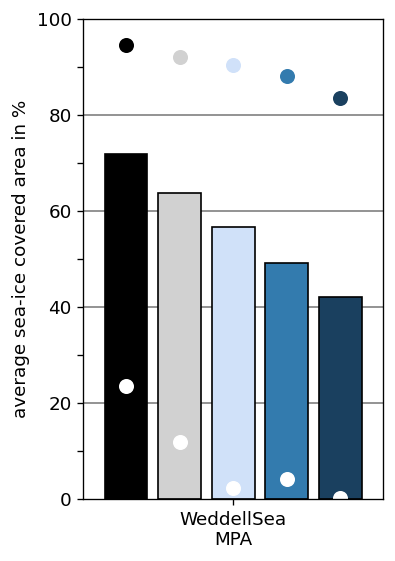

Plot RossSea_MPA
RossSea_MPA , Mean/Min/Max historical: 52.38761901855469 1.3761045411229134 81.53629302978516
RossSea_MPA , Mean/Min/Max ssp126: 49.35014724731445 1.4488019049167633 80.82130551338196
RossSea_MPA , Mean/Min/Max ssp245: 44.94460582733154 0.8902805857360363 78.11238765716553
RossSea_MPA , Mean/Min/Max ssp370: 41.70593738555908 0.715854624286294 74.98453855514526
RossSea_MPA , Mean/Min/Max ssp585: 38.45134973526001 0.14159067068248987 72.26456999778748



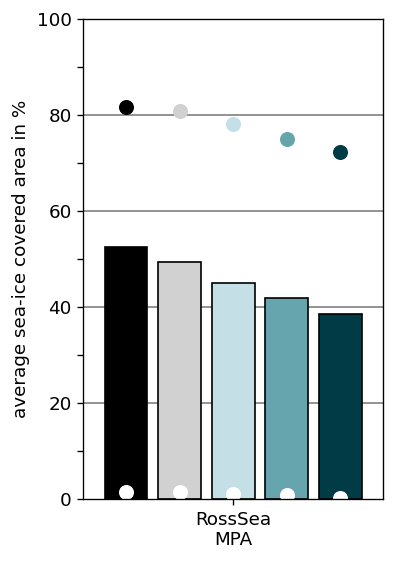

Plot East_Antarctica_all_MPA
East_Antarctica_all_MPA , Mean/Min/Max historical: 38.10014486312866 4.2671885580602975e-05 75.62503814697266
East_Antarctica_all_MPA , Mean/Min/Max ssp126: 30.15742778778076 0.05900397663936019 68.24725866317749
East_Antarctica_all_MPA , Mean/Min/Max ssp245: 23.83219003677368 0.0 65.43223261833191
East_Antarctica_all_MPA , Mean/Min/Max ssp370: 20.28843641281128 0.0 56.02785348892212
East_Antarctica_all_MPA , Mean/Min/Max ssp585: 17.932913303375244 0.0 53.51189374923706



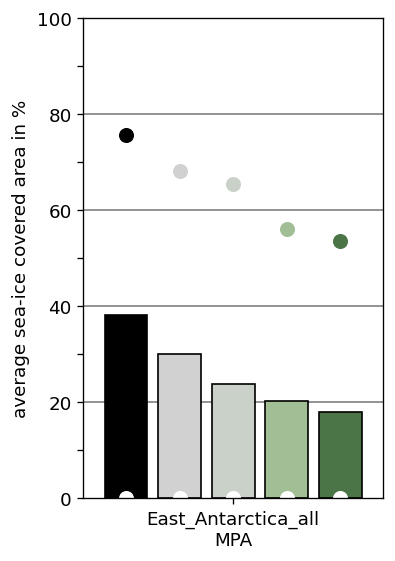

Plot AntarcticPeninsula_MPA
AntarcticPeninsula_MPA , Mean/Min/Max historical: 43.183135986328125 4.5054033398628235 81.72128796577454
AntarcticPeninsula_MPA , Mean/Min/Max ssp126: 43.5996675491333 2.807886153459549 84.54042673110962
AntarcticPeninsula_MPA , Mean/Min/Max ssp245: 28.094830513000492 0.8924314752221107 74.99814033508301
AntarcticPeninsula_MPA , Mean/Min/Max ssp370: 23.738136291503906 0.29105558060109615 72.23613858222961
AntarcticPeninsula_MPA , Mean/Min/Max ssp585: 19.147579669952393 0.09250242146663368 67.35201478004456



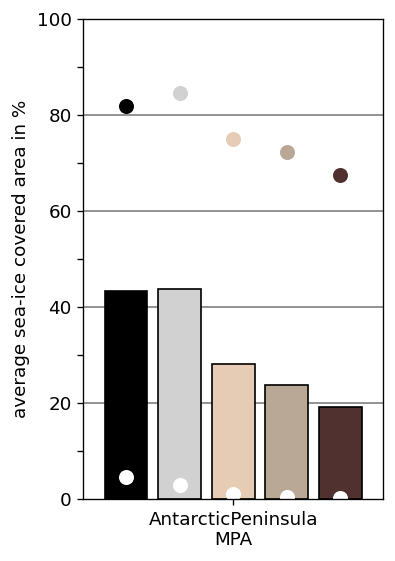

Plot Orkney_MPA
Orkney_MPA , Mean/Min/Max historical: 42.94239044189453 0.0 90.6201720237732
Orkney_MPA , Mean/Min/Max ssp126: 43.397111892700195 0.0 92.32169985771179
Orkney_MPA , Mean/Min/Max ssp245: 30.061538219451904 0.0 79.34289574623108
Orkney_MPA , Mean/Min/Max ssp370: 22.602684497833252 0.0 73.645681142807
Orkney_MPA , Mean/Min/Max ssp585: 24.654724597930908 0.0 72.6094663143158



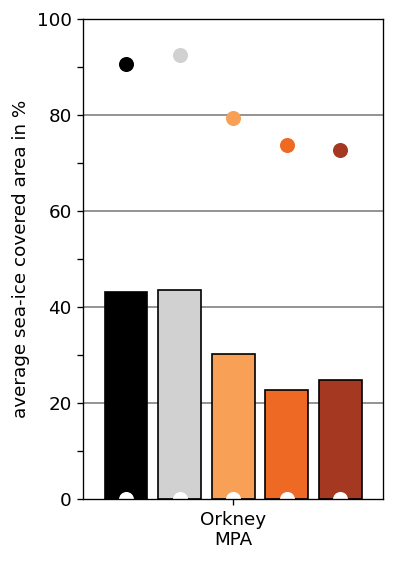

Plot WeddellSea_MPA_shelf
WeddellSea_MPA_shelf , Mean/Min/Max historical: 78.17412376403809 35.39423644542694 94.12518739700317
WeddellSea_MPA_shelf , Mean/Min/Max ssp126: 70.32764434814453 22.166287899017334 92.63661503791809
WeddellSea_MPA_shelf , Mean/Min/Max ssp245: 64.07153129577637 4.071523621678352 91.2645936012268
WeddellSea_MPA_shelf , Mean/Min/Max ssp370: 56.92978858947754 7.563592493534088 92.41568446159363
WeddellSea_MPA_shelf , Mean/Min/Max ssp585: 48.63851547241211 0.14381797518581152 86.91676259040833



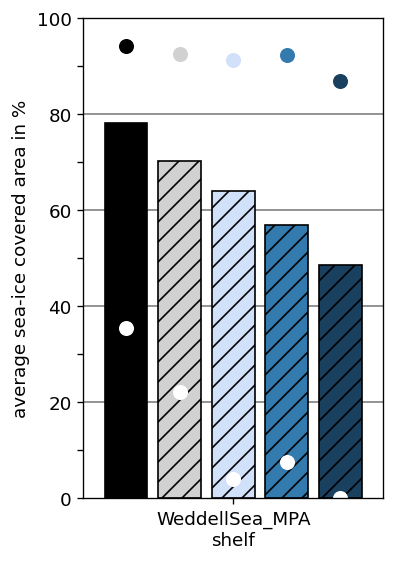

Plot RossSea_MPA_shelf
RossSea_MPA_shelf , Mean/Min/Max historical: 62.64167785644531 2.0593494176864624 90.96882939338684
RossSea_MPA_shelf , Mean/Min/Max ssp126: 61.30248546600342 2.6189567521214485 91.23923778533936
RossSea_MPA_shelf , Mean/Min/Max ssp245: 57.15950012207032 0.733393058180809 88.82713317871094
RossSea_MPA_shelf , Mean/Min/Max ssp370: 54.21149253845214 1.4123890548944473 88.44460248947144
RossSea_MPA_shelf , Mean/Min/Max ssp585: 50.994863510131836 0.25757751427590847 85.67023873329163



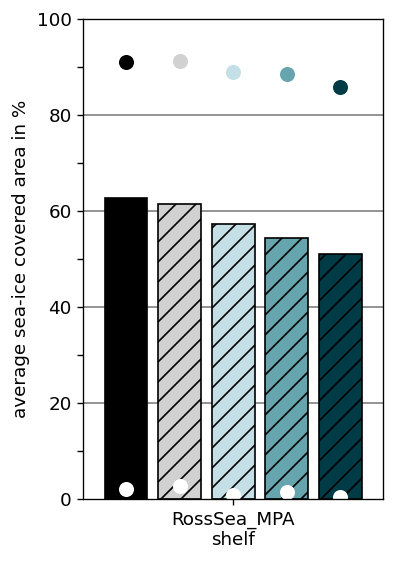

Plot East_Antarctica_all_MPA_shelf
East_Antarctica_all_MPA_shelf , Mean/Min/Max historical: 50.13934135437012 0.0001529933570054709 82.16919302940369
East_Antarctica_all_MPA_shelf , Mean/Min/Max ssp126: 44.28158760070801 0.21154950372874737 77.3814857006073
East_Antarctica_all_MPA_shelf , Mean/Min/Max ssp245: 39.294729232788086 0.0 78.72933745384216
East_Antarctica_all_MPA_shelf , Mean/Min/Max ssp370: 38.013339042663574 0.0 76.69273614883423
East_Antarctica_all_MPA_shelf , Mean/Min/Max ssp585: 34.552743434906006 0.0 74.50736165046692



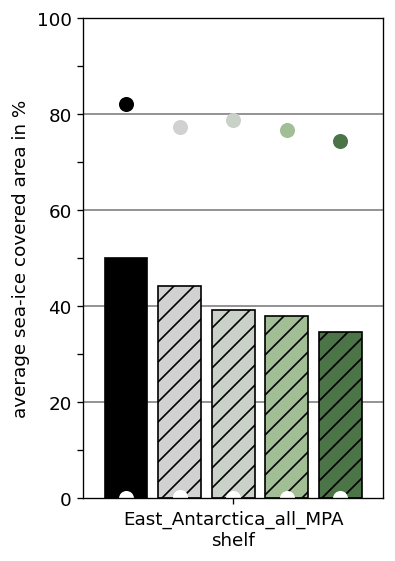

Plot AntarcticPeninsula_MPA_shelf
AntarcticPeninsula_MPA_shelf , Mean/Min/Max historical: 50.066108703613274 6.148167327046394 83.97257328033447
AntarcticPeninsula_MPA_shelf , Mean/Min/Max ssp126: 50.170111656188965 3.8316991180181503 86.36566996574402
AntarcticPeninsula_MPA_shelf , Mean/Min/Max ssp245: 33.96874666213989 1.2178306467831135 78.2011330127716
AntarcticPeninsula_MPA_shelf , Mean/Min/Max ssp370: 29.37006950378418 0.3971804864704609 76.04222297668457
AntarcticPeninsula_MPA_shelf , Mean/Min/Max ssp585: 23.320815563201904 0.12623071670532227 71.75178527832031



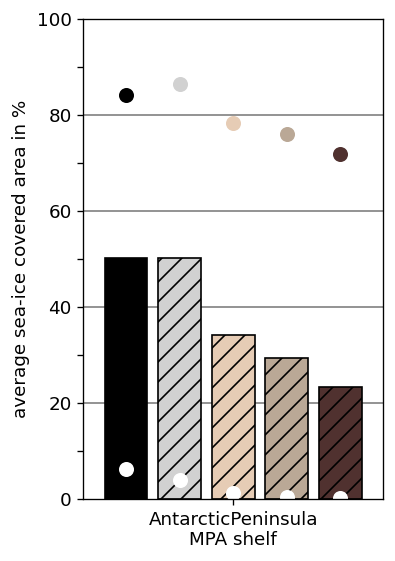

In [13]:
#----
# PLOTTING
#----

save_plot = False
display_plot = True
plot_eps = False

dpicnt = 120
cs = 12
sh = 0.3
ec='k'
width1=0.4
fs=11
color1 = 'k'
color2 = 'grey'
color3 = 'lightblue'
shift1 = 0.2
shift2 = 0.4
xlim1,xlim2 = -0.25,3.75

x_pos = [0,0.5,1,1.5,2,\
        3,3.5,4,4.5,5,\
        6,6.5,7,7.5,8,\
        9,9.5,10,10.5,11,\
        12,12.5,13,13.5,14,\
        15,15.5,16,16.5,17]
    
reg_list = ["WeddellSea_MPA","RossSea_MPA","East_Antarctica_all_MPA","AntarcticPeninsula_MPA","Orkney_MPA",\
           "WeddellSea_MPA_shelf","RossSea_MPA_shelf","East_Antarctica_all_MPA_shelf",\
           "AntarcticPeninsula_MPA_shelf"]
reg_list2 = ["WeddellSea\nMPA","RossSea\nMPA","East_Antarctica_all\nMPA","AntarcticPeninsula\nMPA","Orkney\nMPA",\
           "WeddellSea_MPA\nshelf","RossSea_MPA\nshelf","East_Antarctica_all_MPA\nshelf",\
            "AntarcticPeninsula\nMPA shelf"]

def plot_bars_1region(data1,data2,data3,data4,factor,subregions,subregions_in_file,\
                      region_to_plot,x_pos,color_list,ec,width,area_list,ind_reg,vari):
    ind_reg  = subregions.index(region_to_plot)
    ind_reg2 = subregions_in_file.index(region_to_plot)
    if vari in ['seaice','sea ice']:
        data_plot = np.mean(data1,axis=0)[:,ind_reg2]/area_list[ind_reg]
        data_plot2 = np.mean(data2,axis=0)[:,ind_reg2]/area_list[ind_reg]
        data_plot3 = np.mean(data3,axis=0)[:,ind_reg2]/area_list[ind_reg]
        data_plot4 = np.mean(data4,axis=0)[:,ind_reg2]/area_list[ind_reg]
        # get annual min
        data_plot_min = np.min(data1,axis=0)[:,ind_reg2]/area_list[ind_reg]
        data_plot2_min = np.min(data2,axis=0)[:,ind_reg2]/area_list[ind_reg]
        data_plot3_min = np.min(data3,axis=0)[:,ind_reg2]/area_list[ind_reg]
        data_plot4_min = np.min(data4,axis=0)[:,ind_reg2]/area_list[ind_reg]
        # get annual max
        data_plot_max = np.max(data1,axis=0)[:,ind_reg2]/area_list[ind_reg]
        data_plot2_max = np.max(data2,axis=0)[:,ind_reg2]/area_list[ind_reg]
        data_plot3_max = np.max(data3,axis=0)[:,ind_reg2]/area_list[ind_reg]
        data_plot4_max = np.max(data4,axis=0)[:,ind_reg2]/area_list[ind_reg]
    elif vari in ['basal_melt','basal melt']:
        data_plot = np.mean(data1,axis=0)[:,ind_reg2]
        data_plot2 = np.mean(data2,axis=0)[:,ind_reg2]
        data_plot3 = np.mean(data3,axis=0)[:,ind_reg2]
        data_plot4 = np.mean(data4,axis=0)[:,ind_reg2]
    a1 = np.mean(data_plot[0:9+1])
    a2 = np.mean(data_plot4[76:85+1]) # ssp126
    a3 = np.mean(data_plot3[76:85+1])
    a4 = np.mean(data_plot2[76:85+1])
    a5 = np.mean(data_plot[100:109+1]) # ssp585
    if vari in ['seaice','sea ice']:
        # annual min
        b1 = np.min(data_plot_min[0:9+1])
        b2 = np.min(data_plot4_min[76:85+1]) # ssp126
        b3 = np.min(data_plot3_min[76:85+1])
        b4 = np.min(data_plot2_min[76:85+1])
        b5 = np.min(data_plot_min[100:109+1]) # ssp585
        # annual max
        c1 = np.max(data_plot_max[0:9+1])
        c2 = np.max(data_plot4_max[76:85+1]) # ssp126
        c3 = np.max(data_plot3_max[76:85+1])
        c4 = np.max(data_plot2_max[76:85+1])
        c5 = np.max(data_plot_max[100:109+1]) # ssp585
    if region_to_plot in ["WeddellSea_MPA_shelf",\
                          "RossSea_MPA_shelf","East_Antarctica_all_MPA_shelf",\
                         "AntarcticPeninsula_MPA_shelf"]:
        hatch1="//"
        plt.bar(x_pos[0],factor*a1,color='k',edgecolor=ec,width=width1,hatch=hatch1) 
        plt.bar(x_pos[1],factor*a2,color=color_list[3],edgecolor=ec,width=width1,hatch=hatch1) 
        plt.bar(x_pos[2],factor*a3,color=color_list[2],edgecolor=ec,width=width1,hatch=hatch1) 
        plt.bar(x_pos[3],factor*a4,color=color_list[1],edgecolor=ec,width=width1,hatch=hatch1) 
        plt.bar(x_pos[4],factor*a5,color=color_list[0],edgecolor=ec,width=width1,hatch=hatch1)
    else:
        plt.bar(x_pos[0],factor*a1,color='k',edgecolor=ec,width=width1) 
        plt.bar(x_pos[1],factor*a2,color=color_list[3],edgecolor=ec,width=width1) 
        plt.bar(x_pos[2],factor*a3,color=color_list[2],edgecolor=ec,width=width1) 
        plt.bar(x_pos[3],factor*a4,color=color_list[1],edgecolor=ec,width=width1) 
        plt.bar(x_pos[4],factor*a5,color=color_list[0],edgecolor=ec,width=width1)
    # for sea ice, add annual min/max
    if vari in ['seaice','sea ice']:
        marker1 = 'o'
        color1 = 'white'
        color2 = 'black'
        ms = 8
        plt.hlines(20,-0.4,2.4,color='gray',linewidth=1,zorder=0)
        plt.hlines(40,-0.4,2.4,color='gray',linewidth=1,zorder=0)
        plt.hlines(60,-0.4,2.4,color='gray',linewidth=1,zorder=0)
        plt.hlines(80,-0.4,2.4,color='gray',linewidth=1,zorder=0)
        print(region_to_plot,', Mean/Min/Max historical:',factor*a1,factor*b1,factor*c1)
        print(region_to_plot,', Mean/Min/Max ssp126:',factor*a2,factor*b2,factor*c2)
        print(region_to_plot,', Mean/Min/Max ssp245:',factor*a3,factor*b3,factor*c3)
        print(region_to_plot,', Mean/Min/Max ssp370:',factor*a4,factor*b4,factor*c4)
        print(region_to_plot,', Mean/Min/Max ssp585:',factor*a5,factor*b5,factor*c5)
        print()
        # annual min
        plt.plot(x_pos[0],factor*b1,marker=marker1,color=color1,markersize=ms)
        plt.plot(x_pos[1],factor*b2,marker=marker1,color=color1,markersize=ms)
        plt.plot(x_pos[2],factor*b3,marker=marker1,color=color1,markersize=ms)
        plt.plot(x_pos[3],factor*b4,marker=marker1,color=color1,markersize=ms)
        plt.plot(x_pos[4],factor*b5,marker=marker1,color=color1,markersize=ms)
        # annual max
        plt.plot(x_pos[0],factor*c1,marker=marker1,color=color2,markersize=ms)
        plt.plot(x_pos[1],factor*c2,marker=marker1,color=color_list[3],markersize=ms)
        plt.plot(x_pos[2],factor*c3,marker=marker1,color=color_list[2],markersize=ms)
        plt.plot(x_pos[3],factor*c4,marker=marker1,color=color_list[1],markersize=ms)
        plt.plot(x_pos[4],factor*c5,marker=marker1,color=color_list[0],markersize=ms)
    else:
        print(region_to_plot,a1,a5)

#----
# SEA ICE
#----
vari = 'sea ice'
factor = 100

for rr in range(0,len(reg_list)):
    print('Plot',reg_list[rr])
    
    if reg_list[rr] in ['RossSea_MPA','RossSea_MPA_openOcean','RossSea_MPA_shelf']: # pine
        color_list = color_list1
    elif reg_list[rr] in ['East_Antarctica_all_MPA','East_Antarctica_all_MPA_openOcean','East_Antarctica_all_MPA_shelf']: # sage
        color_list = color_list2
    elif reg_list[rr] in ['WeddellSea_MPA','WeddellSea_MPA_openOcean','WeddellSea_MPA_shelf']: # indigo
        color_list = color_list3
    elif reg_list[rr] in ['Orkney_MPA']: # blue
        color_list = color_list4
    elif reg_list[rr] in ['AntarcticPeninsula_MPA','AntarcticPeninsula_MPA_openOcean','AntarcticPeninsula_MPA_shelf']: # warm grey
        color_list = color_list5
    else:
        color_list = color_list6

    fig7= plt.figure(num=18, figsize=(2.5,4), dpi=dpicnt, facecolor='w', edgecolor='k')
    ax = fig7.add_axes([0, 0, 1, 1])
    plot_bars_1region(sea_ice1,sea_ice2,sea_ice3,sea_ice4,factor,subregions,subregions_in_file,\
                      reg_list[rr],x_pos[0:5+1],color_list,ec,width1,area_list,ind_reg,vari)
    plt.xticks([x_pos[2]],[reg_list2[rr]],fontsize=fs)
    plt.xlim((-0.4,2.4))
    plt.ylabel('average sea-ice covered area in %',fontsize=fs)
    plt.yticks([0,10,20,30,40,50,60,70,80,90,100],[0,'',20,'',40,'',60,'',80,'',100],fontsize=fs)
    if save_plot:
        filename = 'BarPlot_sea_ice_cover_1990s_vs_2090s_'+reg_list[rr]+'.png'
        plt.savefig(savepath1+filename,dpi = dpicnt, bbox_inches='tight')
        del filename
    if display_plot:
        plt.show()
    else:
        plt.close(fig7)
        
    #---
    # eps
    #---
    if plot_eps:
        fig7= plt.figure(num=18, figsize=(2.5,4), dpi=dpicnt, facecolor='w', edgecolor='k')
        ax = fig7.add_axes([0, 0, 1, 1])
        plot_bars_1region(sea_ice1,sea_ice2,sea_ice3,sea_ice4,factor,subregions,subregions_in_file,\
                          reg_list[rr],x_pos[0:5+1],color_list,ec,width1,area_list,ind_reg,vari)
        plt.xticks([x_pos[2]],[],fontsize=fs-2)
        #plt.legend(frameon=False)
        plt.xlim((-0.4,2.4))
        plt.yticks([0,10,20,30,40,50,60,70,80,90,100],[],fontsize=fs)
        if save_plot:
            filename = 'BarPlot_sea_ice_cover_1990s_vs_2090s_'+reg_list[rr]+'.eps'
            plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
            del filename
        if display_plot:
            plt.show()
        else:
            plt.close(fig7)
        
       
    

Plot WeddellSea_MPA
WeddellSea_MPA 154847510000.0 294544150000.0


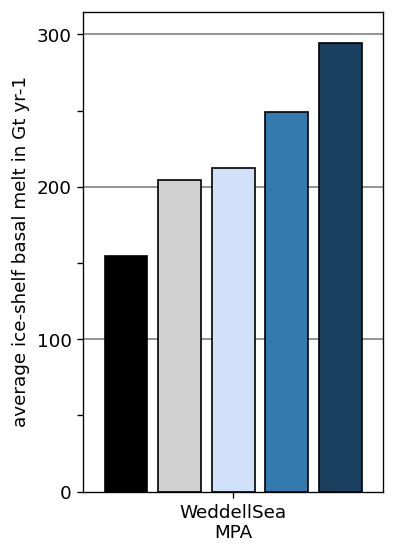

Plot RossSea_MPA
RossSea_MPA 210352520000.0 208443380000.0


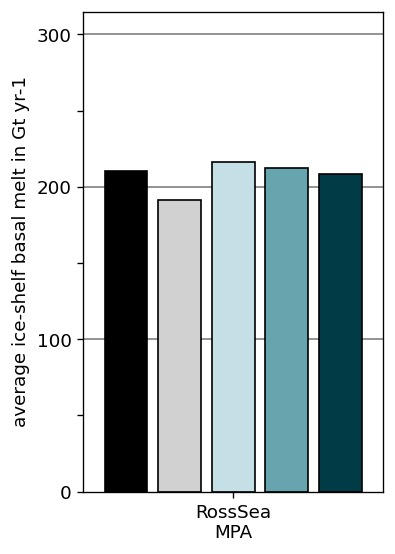

Plot East_Antarctica_all_MPA
East_Antarctica_all_MPA 10693304000.0 25200550000.0


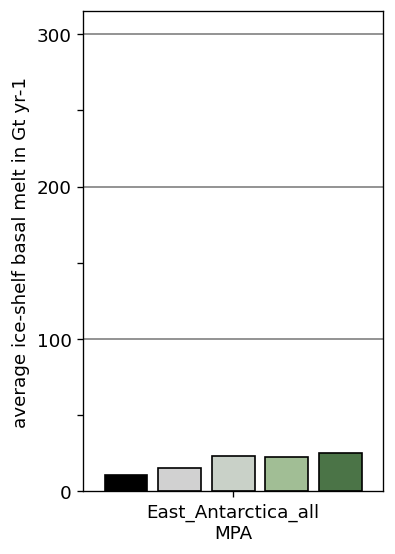

Plot AntarcticPeninsula_MPA
AntarcticPeninsula_MPA 67964314000.0 34514498000.0


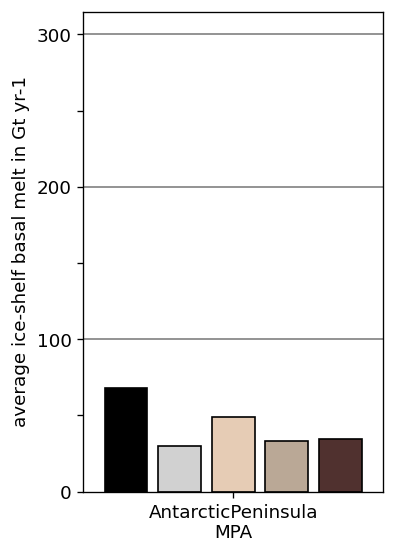

Plot Orkney_MPA
Orkney_MPA nan nan


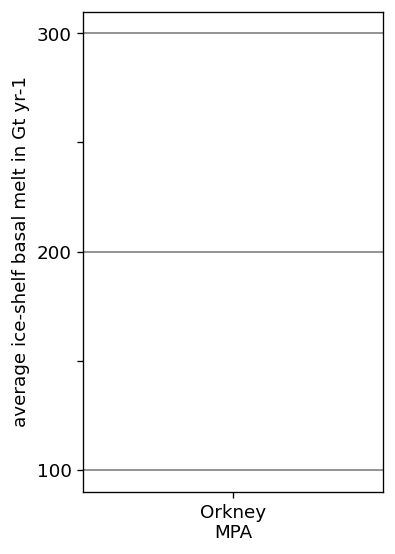

In [15]:
#----
# BASAL MELT
#----
vari = 'basal_melt'
factor = 1/(1000000000)

reg_list = ["WeddellSea_MPA","RossSea_MPA","East_Antarctica_all_MPA","AntarcticPeninsula_MPA","Orkney_MPA"]

for rr in range(0,len(reg_list)):
    print('Plot',reg_list[rr])
    
    if reg_list[rr] in ['RossSea_MPA','RossSea_MPA_openOcean','RossSea_MPA_shelf']: # pine
        color_list = color_list1
    elif reg_list[rr] in ['East_Antarctica_all_MPA','East_Antarctica_all_MPA_openOcean','East_Antarctica_all_MPA_shelf']: # sage
        color_list = color_list2
    elif reg_list[rr] in ['WeddellSea_MPA','WeddellSea_MPA_openOcean','WeddellSea_MPA_shelf']: # indigo
        color_list = color_list3
    elif reg_list[rr] in ['Orkney_MPA']: # blue
        color_list = color_list4
    elif reg_list[rr] in ['AntarcticPeninsula_MPA']: # warm grey
        color_list = color_list5
    else:
        color_list = color_list6

    fig7= plt.figure(num=18, figsize=(2.5,4), dpi=dpicnt, facecolor='w', edgecolor='k')
    ax = fig7.add_axes([0, 0, 1, 1])
    plot_bars_1region(basal1,basal2,basal3,basal4,factor,subregions,subregions_in_file,\
                      reg_list[rr],x_pos[0:5+1],color_list,ec,width1,area_list,ind_reg,vari)
    plt.xticks([x_pos[2]],[reg_list2[rr]],fontsize=fs)
    plt.xlim((-0.4,2.4))
    plt.ylabel('average ice-shelf basal melt in Gt yr-1',fontsize=fs)
    plt.yticks([0,50,100,150,200,250,300],[0,'',100,'',200,'',300],fontsize=fs)
    plt.hlines(100,-0.4,2.4,color='gray',linewidth=1,zorder=0)
    plt.hlines(200,-0.4,2.4,color='gray',linewidth=1,zorder=0)
    plt.hlines(300,-0.4,2.4,color='gray',linewidth=1,zorder=0)
    if save_plot:
        filename = 'BarPlot_basal_melt_1990s_vs_2090s_'+reg_list[rr]+'.png'
        plt.savefig(savepath1+filename,dpi = dpicnt, bbox_inches='tight')
        del filename
    if display_plot:
        plt.show()
    else:
        plt.close(fig7)
        
    #---
    # eps
    #---
    if plot_eps:
        fig7= plt.figure(num=18, figsize=(2.5,4), dpi=dpicnt, facecolor='w', edgecolor='k')
        ax = fig7.add_axes([0, 0, 1, 1])
        plot_bars_1region(basal1,basal2,basal3,basal4,factor,subregions,subregions_in_file,\
                          reg_list[rr],x_pos[0:5+1],color_list,ec,width1,area_list,ind_reg,vari)
        plt.xticks([x_pos[2]],[],fontsize=fs)
        plt.xlim((-0.4,2.4))
        plt.yticks([0,50,100,150,200,250,300],[],fontsize=fs)
        plt.hlines(100,-0.4,2.4,color='gray',linewidth=1,zorder=0)
        plt.hlines(200,-0.4,2.4,color='gray',linewidth=1,zorder=0)
        plt.hlines(300,-0.4,2.4,color='gray',linewidth=1,zorder=0)
        if save_plot:
            filename = 'BarPlot_basal_melt_1990s_vs_2090s_'+reg_list[rr]+'.eps'
            plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
            del filename
        if display_plot:
            plt.show()
        else:
            plt.close(fig7)
            

In [16]:
print(savepath1)

/global/cfs/cdirs/m4003/cnissen/Plots/Paper_OA_in_MPAs/Fig_seaice_basal_melt/
